## Mount Google Drive

In [1]:
IS_COLAB = False

In [2]:
if IS_COLAB:
    from google.colab import drive
    drive.mount('/gdrive')

In [3]:
if IS_COLAB:
    %cd /gdrive/My Drive/Colab Notebooks/AN2DL1

## Initial configurations: libraries, seed

In [4]:
import os
import enum
import json
from datetime import datetime
import random
from typing import Tuple, Callable, Dict, Optional, List

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Random seed for reproducibility
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED) 

# Check device
tf.test.gpu_device_name()

''

## Load data

In [5]:
ROOT_DIR = os.getcwd()
DATA_DIR = 'data/training_data_final'

if not os.path.exists(DATA_DIR):
    if IS_COLAB:
        !unzip 'data/training_dataset_homework1' -d 'data'
    else:
        raise RuntimeError("data/training_data_final path not found.")

In [6]:
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
IMG_SIZE = (96, 96)
IMG_SHAPE = IMG_SIZE + (3,)

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VALIDATION_SPLIT,
    subset = 'training'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VALIDATION_SPLIT,
    subset = 'validation'
)

Found 3542 files belonging to 8 classes.
Using 2834 files for training.
Found 3542 files belonging to 8 classes.
Using 708 files for validation.


In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 96, 96, 3)
(32,)


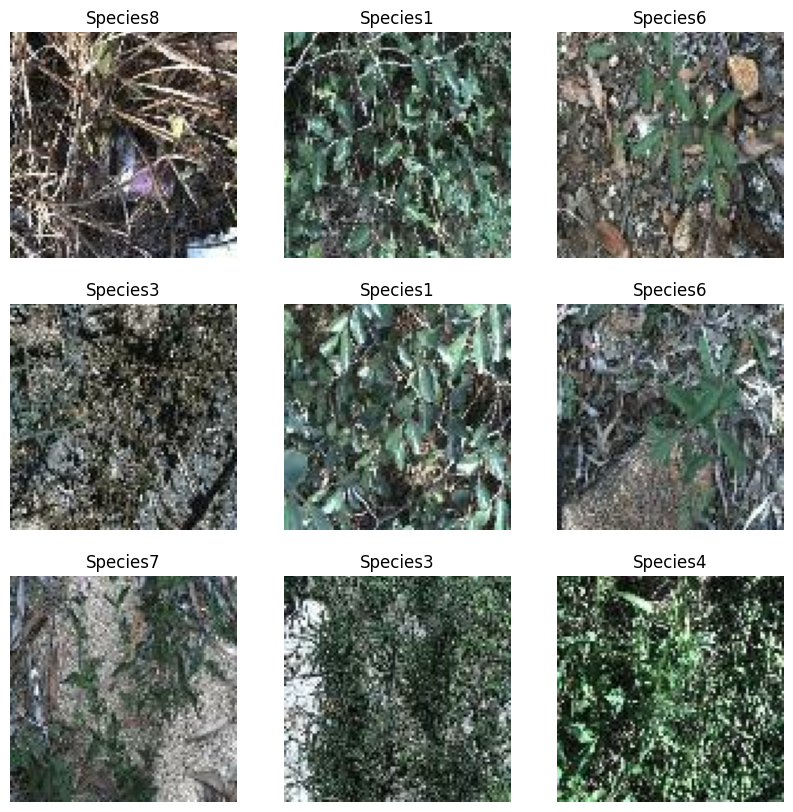

In [8]:
CLASS_NAMES = train_ds.class_names
N_CLASSES = len(CLASS_NAMES)


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASS_NAMES[labels[i]])
    plt.axis("off")

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Preprocessing and Data Augmentation

Rescale images to $[0.0, 1.0]$.

In [10]:
rescale_layer = tf.keras.layers.Rescaling(1./255, name='rescale')

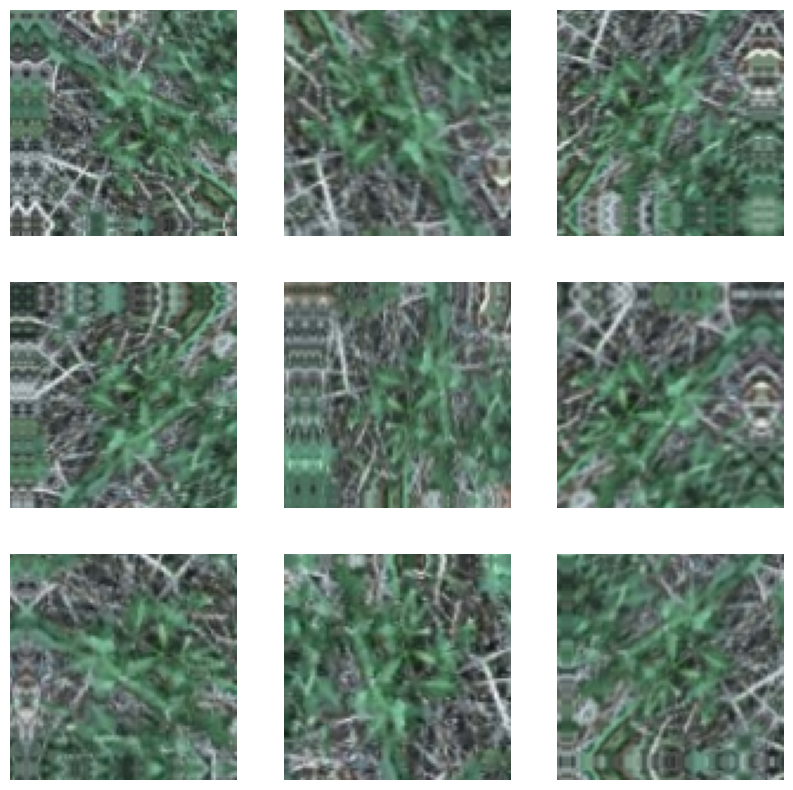

In [11]:
data_augmentation_layer = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomContrast(0.1),
  #tf.keras.layers.RandomBrightness(0.01),
  tf.keras.layers.RandomZoom(0.1),
  tf.keras.layers.RandomTranslation(
    0.1,
    0.1,
  )
], name='data_augmentation')

for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation_layer(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [12]:
feature_extraction_layer = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)
feature_extraction_layer.trainable = False

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D(name='global_average')
prediction_layer = tf.keras.layers.Dense(N_CLASSES, name='prediction')

In [14]:
input_layer = tf.keras.Input(shape=IMG_SHAPE)
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1, name="rescale")

model = tf.keras.Sequential([
    input_layer,
    rescale,
    data_augmentation_layer,
    feature_extraction_layer,
    global_average_layer,
    tf.keras.layers.Dropout(0.2, name="dropout"),
    prediction_layer
])

In [15]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescale (Rescaling)         (None, 96, 96, 3)         0         
                                                                 
 data_augmentation (Sequenti  (None, 96, 96, 3)        0         
 al)                                                             
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_average (GlobalAvera  (None, 1280)             0         
 gePooling2D)                                                    
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                        

## Train

In [37]:
initial_epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=initial_epochs
)

Epoch 1/20
89/89 [==============================] - 28s 213ms/step - loss: 2.4081 - accuracy: 0.1743 - val_loss: 2.0547 - val_accuracy: 0.2387
Epoch 2/20
89/89 [==============================] - 18s 199ms/step - loss: 2.0408 - accuracy: 0.2653 - val_loss: 1.8165 - val_accuracy: 0.3192
Epoch 3/20
89/89 [==============================] - 18s 203ms/step - loss: 1.8254 - accuracy: 0.3419 - val_loss: 1.6872 - val_accuracy: 0.3729
Epoch 4/20
89/89 [==============================] - 19s 209ms/step - loss: 1.6930 - accuracy: 0.3705 - val_loss: 1.6433 - val_accuracy: 0.3856
Epoch 5/20
89/89 [==============================] - 18s 200ms/step - loss: 1.5991 - accuracy: 0.4093 - val_loss: 1.5684 - val_accuracy: 0.4280
Epoch 6/20
89/89 [==============================] - 19s 219ms/step - loss: 1.5253 - accuracy: 0.4203 - val_loss: 1.5266 - val_accuracy: 0.4393
Epoch 7/20
89/89 [==============================] - 18s 202ms/step - loss: 1.4683 - accuracy: 0.4502 - val_loss: 1.5187 - val_accuracy: 0.4477

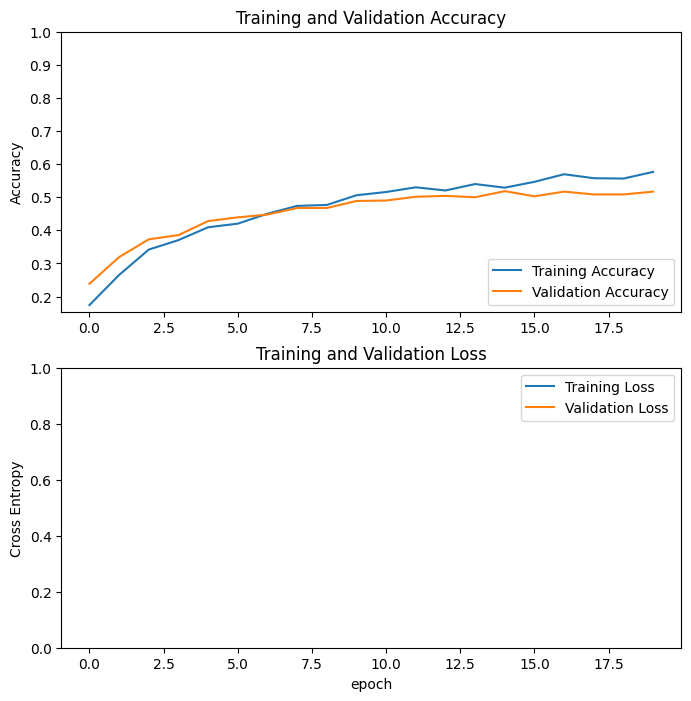

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Fine tuning

In [17]:
feature_extraction_layer.trainable = True

In [18]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(feature_extraction_layer.layers))

Number of layers in the base model:  154


In [19]:
# Fine-tune from this layer onwards
fine_tune_at = 100
for layer in feature_extraction_layer.layers[:fine_tune_at]:
  layer.trainable = False

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescale (Rescaling)         (None, 96, 96, 3)         0         
                                                                 
 data_augmentation (Sequenti  (None, 96, 96, 3)        0         
 al)                                                             
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_average (GlobalAvera  (None, 1280)             0         
 gePooling2D)                                                    
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                        

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Save model

In [ ]:
model_directory = 'models/' + datetime.today().strftime('%Y-%m-%d-%H-%M-%S')
model.save(model_directory)

In [ ]:
if IS_COLAB:
    from google.colab import files
    files.download(model_directory) 